In [9]:
# 使用 COCO資料集 訓練好的權重檔
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")    # 讀取模型資訊，請確認權重檔(.weights)與設定檔(.cfg)的存放路徑!!
layer_names = net.getLayerNames()                        # 獲取每層的名稱
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()] # 獲取輸出層: ['yolo_139', 'yolo_150', 'yolo_161']
classes = [line.strip() for line in open("coco.names")]  # 讀取coco.names的80個類別名稱
print("標籤數量:", len(classes))
print("標籤名稱:", classes)

# 設定不同標籤所顯示的顏色
colors = []
for i in range(len(classes)):
    colors.append((int(random.uniform(0, 255)), int(random.uniform(0, 255)), int(random.uniform(0, 255))))

標籤數量: 80
標籤名稱: ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [20]:
# 沒有使用 非最大抑制 (Non-Maximum Suppression, NMS) 過濾辨識框!!
def yolo_detect(img):
    height, width, channels = img.shape                                                  # 讀取影像資訊：高、寬、通道
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (608, 608), (0, 0, 0), True, crop=False)  # 進行影像前處理
    net.setInput(blob)                                                                   # 將前處理後的影像輸入模型
    outs = net.forward(output_layers)                                                    # 前向傳播獲得該影像的模型預測結果
    #print("outs",outs)
    # 取出預測結果的各項資訊: 外框座標, 自信度(是否為有效物件), 預測標籤(index)
    boxes, confidences, class_ids = [], [], [] 
    for out in outs:
        #print("out",out)
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            scores = detection[5:]
            class_id = np.argmax(scores)
            if confidence>0.5:
                center_x = int(tx*width)
                center_y = int(ty*height)
                w = int(tw*width)
                h = int(th*height)
                x = int(center_x-w/2)
                y = int(center_y-h/2)
                boxes.append([x, y, w, h])                                           # 儲存左上角 x, y與 w,h，提供繪製使用
                confidences.append(float(confidence))                                # 儲存自信度
                class_ids.append(class_id)                                           # 儲存最高機率的類別index(答案)
    
    for i in range(len(boxes)):
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        cv2.rectangle(img, (x, y), (x+w, y+h), colors[class_ids[i]], 2)
        cv2.putText(img, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[class_ids[i]], 1)
    return img


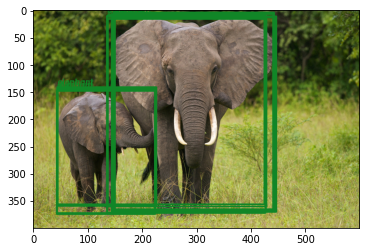

In [22]:
img = cv2.imread("elephant.jpg")
img = yolo_detect(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [36]:
def yolo_detect(img):
    height, width, channels = img.shape                                                  # 讀取影像資訊：高、寬、通道
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (608, 608), (0, 0, 0), True, crop=False)  # 進行影像前處理
    net.setInput(blob)                                                                   # 將前處理後的影像輸入模型
    outs = net.forward(output_layers)                                                    # 前向傳播獲得該影像的模型預測結果
    
    # 取出預測結果的各項資訊: 外框座標, 自信度(是否為有效物件), 預測標籤(index)
    boxes, confidences, class_ids = [], [], [] 
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            scores = detection[5:]
            class_id = np.argmax(scores)
            if confidence>0.5:
                center_x = int(tx*width)
                center_y = int(ty*height)
                w = int(tw*width)
                h = int(th*height)
                x = int(center_x-w/2)
                y = int(center_y-h/2)
                boxes.append([x, y, w, h])                                           # 儲存左上角 x, y與 w,h，提供繪製使用
                confidences.append(float(confidence))                                # 儲存自信度
                class_ids.append(class_id)                                           # 儲存最高機率的類別index(答案)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.5)                         # 非最大抑制方法移除重疊邊界框
    
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            cv2.rectangle(img, (x, y), (x+w, y+h), colors[class_ids[i]], 4)
            cv2.putText(img, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[class_ids[i]], 3)
    return img


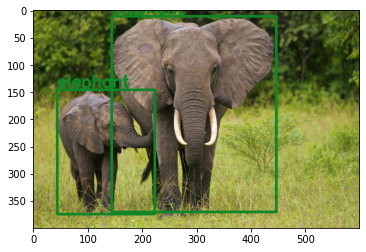

In [37]:
img = cv2.imread("elephant.jpg")
img = yolo_detect(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
# 啟用攝影機!!
cap = cv2.VideoCapture(0)
while True:
    hasFrame, img = cap.read()
    img = yolo_detect(img)
    cv2.imshow("Frame", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

net = cv2.dnn.readNet("yolov4-tiny_final.weights", "yolov4-tiny.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
classes = [line.strip() for line in open("mask.names")]
print("標籤名稱：", classes)

colors = []
for i in range(len(classes)):
    colors.append((int(random.uniform(0, 255)), int(random.uniform(0, 255)), int(random.uniform(0, 255))))

ㄆ標籤名稱： ['none', 'bad', 'good']


In [15]:
def yolo_detect(img):
    height, width, channels = img.shape
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    boxes, confidences, class_ids = [], [], [] 
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            scores = detection[5:]
            class_id = np.argmax(scores)
            if confidence>0.5:
                center_x = int(tx*width)
                center_y = int(ty*height)
                w = int(tw*width)
                h = int(th*height)
                x = int(center_x-w/2)
                y = int(center_y-h/2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.5)
    
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            cv2.rectangle(img, (x, y), (x+w, y+h), colors[class_ids[i]], 4)
            cv2.putText(img, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[class_ids[i]], 1)
    return img

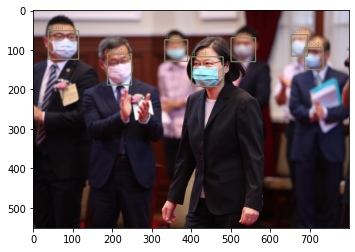

In [16]:
img = cv2.imread("test.jpg")
img = yolo_detect(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [13]:
cap = cv2.VideoCapture(0)
while True:
    hasFrame, img = cap.read()
    img = yolo_detect(img)
    cv2.imshow("Frame", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


In [25]:
print("layer_names:",layer_names,end="\n\n")
print("output_layers:",output_layers)

layer_names: ('conv_0', 'bn_0', 'mish_1', 'conv_1', 'bn_1', 'mish_2', 'conv_2', 'bn_2', 'mish_3', 'identity_3', 'conv_4', 'bn_4', 'mish_5', 'conv_5', 'bn_5', 'mish_6', 'conv_6', 'bn_6', 'mish_7', 'shortcut_7', 'conv_8', 'bn_8', 'mish_9', 'concat_9', 'conv_10', 'bn_10', 'mish_11', 'conv_11', 'bn_11', 'mish_12', 'conv_12', 'bn_12', 'mish_13', 'identity_13', 'conv_14', 'bn_14', 'mish_15', 'conv_15', 'bn_15', 'mish_16', 'conv_16', 'bn_16', 'mish_17', 'shortcut_17', 'conv_18', 'bn_18', 'mish_19', 'conv_19', 'bn_19', 'mish_20', 'shortcut_20', 'conv_21', 'bn_21', 'mish_22', 'concat_22', 'conv_23', 'bn_23', 'mish_24', 'conv_24', 'bn_24', 'mish_25', 'conv_25', 'bn_25', 'mish_26', 'identity_26', 'conv_27', 'bn_27', 'mish_28', 'conv_28', 'bn_28', 'mish_29', 'conv_29', 'bn_29', 'mish_30', 'shortcut_30', 'conv_31', 'bn_31', 'mish_32', 'conv_32', 'bn_32', 'mish_33', 'shortcut_33', 'conv_34', 'bn_34', 'mish_35', 'conv_35', 'bn_35', 'mish_36', 'shortcut_36', 'conv_37', 'bn_37', 'mish_38', 'conv_38', '